### [Shrinkage]

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, CSV
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
m = CSV.read("pd_speech_features.csv", header=false);

In [3]:
X = zeros(size(m,1)-2,size(m,2)-2)
for i in 3:size(m,1) 
    for j in 2:size(m,2)-1 
        X[i-2,j-1] = parse(m[i,j])
    end
end

In [4]:
mu, sd = vec(mean(X[:,2:end],1)), vec(std(X[:,2:end],1))
X_normalised = zeros(size(X))
for i in 1:size(X,1) 
    X_normalised[i,2:end] = (X[i,2:end]-mu)./sd
end
X_normalised = X_normalised';

In [5]:
y = vec([parse(m[i,end]) for i in 3:size(m,1)]);

In [6]:
d, Nobs = size(X_normalised)
σ02 = 1
prior = SS_prior(d, σ02);
d_hyp = hyperparam_size(prior);

In [7]:
my_ll = ll_logistic(X_normalised,y);
my_model = model(my_ll, prior);

In [8]:
# Sub-sampling without control variates and with weights:

mb_size = 1
gs = Array{mbsampler}(d)
gs[1] = umbsampler(0, Nobs, mb_size)

@showprogress for i in 2:d 
    gs[i] = wumbsampler(Nobs, mb_size, abs.(X_normalised[i,:]))
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [15]:
A_xi, A_hyp = zeros(50,d), zeros(50,d_hyp)
for i in 1:50 
    A_xi[i,i], A_hyp[i,i] = 1, 1 
end

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(5*10^7, 10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

In [16]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e2)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [17]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10 percent attempts in 124.99 min; zz bounces = 486963, hyp bounces = 1710, total time of process = 16.953 
20 percent attempts in 238.78 min; zz bounces = 809714, hyp bounces = 3520, total time of process = 35.025 
Trimmed after 10000000 bouncing attempts 
30 percent attempts in 345.20 min; zz bounces = 1083085, hyp bounces = 5308, total time of process = 52.818 
40 percent attempts in 444.31 min; zz bounces = 1343295, hyp bounces = 7062, total time of process = 70.248 
50 percent attempts in 532.83 min; zz bounces = 1599922, hyp bounces = 8769, total time of process = 87.400 
60 percent attempts in 596.88 min; zz bounces = 1838648, hyp bounces = 10475, total time of process = 104.420 
70 percent attempts in 661.38 min; zz bounces = 2075457, hyp bounces = 12233, total time of process = 121.393 
80 percent attempts in 726.69 min; zz bounces = 2314063, hyp bounces = 13958, total time of process = 138.255 
90 percent attempts in 791.85 min; zz bounces = 2549939, hyp bounces = 15635, tota

In [18]:
xi_sd = sqrt.(outp.opf.xi_m2 - outp.opf.xi_mu.^2)
ci = zeros(d,2)
ci[:,1] = outp.opf.xi_mu-3*xi_sd
ci[:,2] = outp.opf.xi_mu+3*xi_sd;

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:00

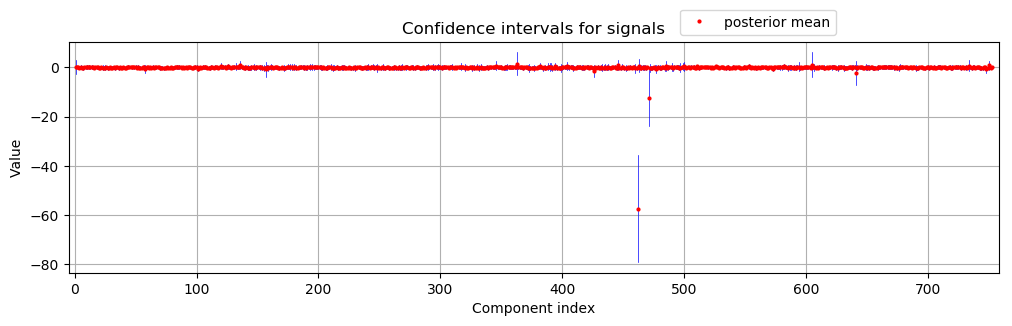

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


PyObject <matplotlib.legend.Legend object at 0x7f4e4e04bd30>

In [19]:
fig = figure(figsize=(12,3))
@showprogress for i in 1:d
    plot([i,i], ci[i,:], "b-", lw=0.5)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=2, label="posterior mean");
grid(true)
xlim(-5,d+5)
xlabel("Component index")
ylabel("Value")
title("Confidence intervals for signals")
legend(ncol=2,bbox_to_anchor=(0.65, 1))

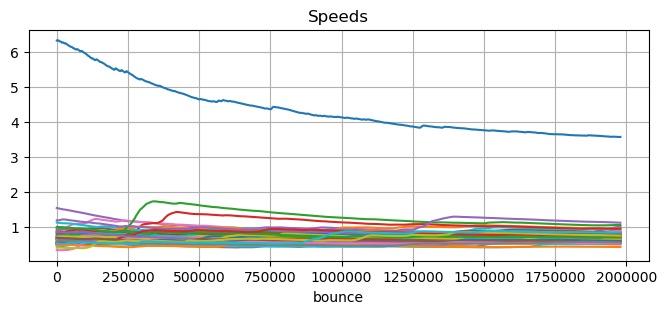

In [20]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:size(outp.opf.alpha_skeleton,1) 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

In [21]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

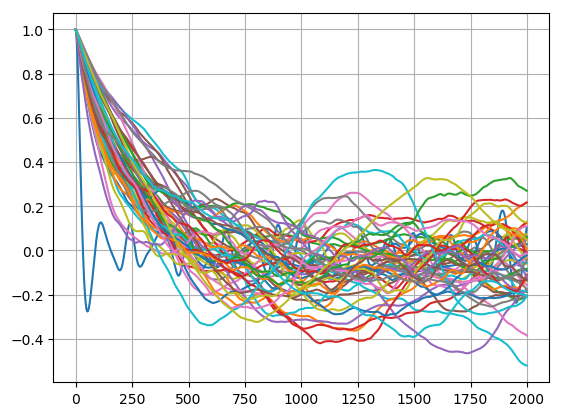

In [22]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 2000))
end
grid(true)

In [24]:
a = [sum(acf(xi_samples[i,:], 5000)) for i in 1:size(xi_samples,1)];

In [26]:
sum(a .< 0)

29

In [28]:
size(a)

(50,)

In [40]:
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 1000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 2000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 3000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 4000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 5000)) for i in 1:size(xi_samples,1)])), "\n")

96.70708792390647
356.36779293608777
260.9927078027484
277.6648437440745
283.05381397151996
